# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import namedtuple, deque
from ddpg_agent import Agent 

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Setup DDPG agent hyperparameters



In [5]:
BATCH_SIZE = 256        
BUFFER_SIZE = int(1e5)  
GAMMA = 0.99            
LR_ACTOR = 1e-4         
LR_CRITIC = 1e-4        
TAU = 1e-3                    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(num_agents, state_size, action_size, random_seed=0, 
              gamma=GAMMA, tau=TAU, replay_buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC)



### 4. Train DDPG agent 


In [6]:
def ddpg(n_episodes=1000, queue=100, eps_start=1.0, eps_end=0.01, eps_decay=0.95, target_score=30.0):
    all_scores = []                        
    scores_window = deque(maxlen=queue)
    eps = eps_start
    for episode in range(1, n_episodes+1):        
        env_info = env.reset(train_mode=True)[brain_name]      
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        while True:
            actions = agent.act(states, eps)                        
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            agent.step(states, actions, rewards, next_states, dones)
            scores += rewards                                  
            states = next_states                               
            if np.any(dones):                                  
                break

        eps = max(eps_end, eps_decay*eps)
        current_episode_avg = np.mean(scores)
        scores_window.append(current_episode_avg)
        all_scores.append(current_episode_avg)
        avg_reward = np.mean(scores_window)        
        print('\rEpisode {}\tAverage Score: {:.2f}\t Total Average Score {:.2f}'.format(episode, current_episode_avg, avg_reward))
        if avg_reward >= target_score and len(scores_window) >= 100:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(episode, avg_reward))
            torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_model.pth')
            break
    return all_scores

In [7]:
scores = ddpg()

Episode 1	Average Score: 0.65	 Total Average Score 0.65
Episode 2	Average Score: 1.13	 Total Average Score 0.89
Episode 3	Average Score: 0.81	 Total Average Score 0.86
Episode 4	Average Score: 1.03	 Total Average Score 0.91
Episode 5	Average Score: 0.86	 Total Average Score 0.90
Episode 6	Average Score: 0.93	 Total Average Score 0.90
Episode 7	Average Score: 1.40	 Total Average Score 0.97
Episode 8	Average Score: 1.15	 Total Average Score 1.00
Episode 9	Average Score: 1.64	 Total Average Score 1.07
Episode 10	Average Score: 1.61	 Total Average Score 1.12
Episode 11	Average Score: 2.17	 Total Average Score 1.22
Episode 12	Average Score: 2.43	 Total Average Score 1.32
Episode 13	Average Score: 4.06	 Total Average Score 1.53
Episode 14	Average Score: 5.32	 Total Average Score 1.80
Episode 15	Average Score: 8.32	 Total Average Score 2.23
Episode 16	Average Score: 12.95	 Total Average Score 2.90
Episode 17	Average Score: 13.73	 Total Average Score 3.54
Episode 18	Average Score: 19.32	 Total

### 5. Plot last 100 episodes


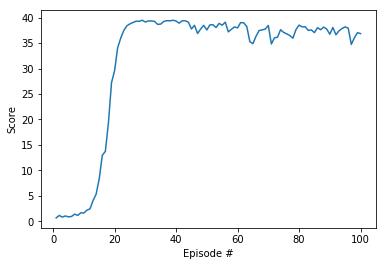

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Load the saved agent and run it!

In [10]:
agent.actor_local.load_state_dict(torch.load('actor_model.pth'))
agent.critic_local.load_state_dict(torch.load('critic_model.pth'))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          

for i in range(1000):
    actions = agent.act(states, 1.0)                    
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    scores += rewards                         
    states = next_states                              
    if np.any(dones):                              
        break
        
env.close()        